# <div style="text-align: center">Random Forests - Kohn-Sham Mapping - Solid-State</div> 
 
## <div style="text-align: center">Jon Vandermause, Steven Torrisi, Simon Batzner</div>
## <div style="text-align: center">Positions-to-Energy </div> 

## Setup 

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from KRR_reproduce import *
import time
import scipy as sp
from scipy.fftpack import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
# setup
ev2kcal = 1/0.043     # conversion factor
SEED = 42
SIM_NO = 201          # total number of data points
M = 180               # number of training points

# random forest
N_ESTIMATORS = 5000   # number of treest
MAX_DEPTH = 200       # maximum depth of trees

# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR']+'/Aluminium_Dataset/Store/'

print("Number of estimators: {}".format(N_ESTIMATORS))
print("Maximum depth: {}".format(MAX_DEPTH))

Number of estimators: 5000
Maximum depth: 200


In [19]:
# load MD results
MD_pos = np.load(STR_PREF+'MD_positions.npy')
MD_ens = np.load(STR_PREF+'MD_energies.npy')

## Load Energies, Positions and Fourier Coefficients

In [20]:
pos = []
ens = []
fours = []

for n in range(SIM_NO):
    # load arrays
    en_curr = np.reshape(np.load(STR_PREF+'en_store/energy'+str(n)+'.npy'),(1))[0]
    pos_curr = np.load(STR_PREF+'pos_store/pos'+str(n)+'.npy')
    four_curr = np.load(STR_PREF+'four_store/four'+str(n)+'.npy')
    
    # store arrays
    ens.append(en_curr)
    pos_curr = pos_curr.flatten()
    pos.append(pos_curr)
    fours.append(four_curr)

# convert to np arrays
ens = np.array(ens)
pos = np.array(pos)
fours = np.array(fours)

## Set up training and test data

In [21]:
data = pos
labels = ens

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,200,M))]
test_indices = [n for n in range(201) if n not in train_indices]

if len(train_indices) != M: 
    print("Size of training set doesn't match the M specified")
    
x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test =np.array([labels[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(180, 12)
(21, 12)
(21,)


## Train Random Forest

In [22]:
estimator = RandomForestRegressor(random_state=SEED, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
estimator.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=200,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Results

In [23]:
# eval on training data
y_true_train, y_pred_train = y_train, estimator.predict(x_train)

# eval on test data
y_true, y_pred = y_test, estimator.predict(x_test)

# print results
print("\nNumber of estimators:\t {}".format(N_ESTIMATORS))
print("Maximum depth:\t\t {}".format(MAX_DEPTH))
print("\n\nMAE on training data in [eV]: \t{}".format(mean_absolute_error(y_true_train, y_pred_train)))
print("MAE on test data in [eV]: \t{}\n\n".format(mean_absolute_error(y_true, y_pred)))
print("\nPrediction on test data:")
print("\n\tPred   |   True\n")
print(np.c_[y_pred, y_true])


Number of estimators:	 5000
Maximum depth:		 200


MAE on training data in [eV]: 	0.011294317949253714
MAE on test data in [eV]: 	0.040916401819833664



Prediction on test data:

	Pred   |   True

[[-227.81921565 -227.84035463]
 [-227.83598756 -227.85027767]
 [-227.77029069 -227.74434902]
 [-227.81381171 -227.82415555]
 [-227.77058393 -227.7375795 ]
 [-227.74848303 -227.60663581]
 [-227.75692019 -227.78045242]
 [-227.67446469 -227.76919887]
 [-227.75889626 -227.60566205]
 [-227.77249977 -227.77281091]
 [-227.79675614 -227.81346283]
 [-227.75834433 -227.67706435]
 [-227.76229886 -227.7940426 ]
 [-227.77757566 -227.8125088 ]
 [-227.82454028 -227.83189815]
 [-227.74311609 -227.77663656]
 [-227.76340278 -227.73537347]
 [-227.8207506  -227.84215562]
 [-227.77338082 -227.74161155]
 [-227.82168403 -227.83667483]
 [-227.7248991  -227.76402925]]


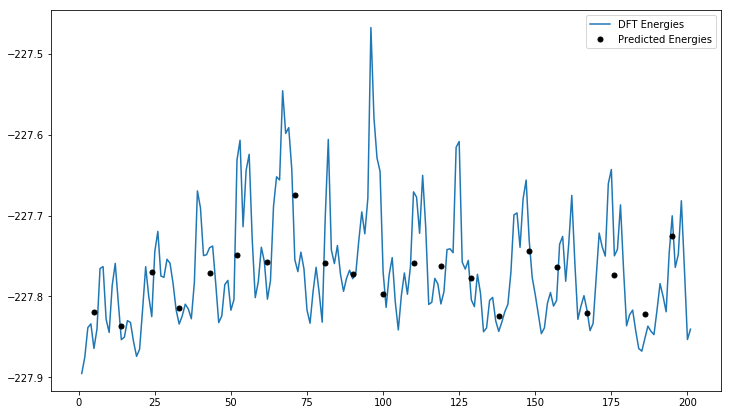

In [29]:
fig = plt.figure(figsize=(12, 7)); 
plt.plot(np.linspace(1, SIM_NO, SIM_NO), ens, label = 'DFT Energies'); 
plt.plot(test_indices, y_pred, 'k.', MarkerSize = 10, mew = 1, label = 'Predicted Energies'); 
plt.legend(); 
plt.show(); 

[1] Brockherde et al. Bypassing the Kohn-Sham equations with machine learning. Nature Communications 8, 872 (2017)